# Анализ объявлений для агенства недвижимости и построение на основании исслудуемых данных Дашборда

## Цель:

### Помощь выхода на рынок Лен. Области агентсву недвижимости из Петрозаводска

### Задачи:

- Анализ времени активности объявлений
- Анализ сезонности объявлений
- Анализ рынка недвижимости Ленобласти
- Общие выводы и рекомендации
  

## Описание данных

**Таблица advertisement:**
- id — идентификатор объявления (первичный ключ).
- first_day_exposition — дата подачи объявления.
- days_exposition — длительность нахождения объявления на сайте (в днях).
- last_price — стоимость квартиры в объявлении, в руб.

**Таблица flats:**

- id — идентификатор квартиры (первичный ключ, связан с первичным ключом id таблицы advertisement).
- city_id — идентификатор города (внешний ключ, связан с city_id таблицы city).
- type_id — идентификатор типа населённого пункта (внешний ключ, связан с type_id таблицы type).
- total_area — общая площадь квартиры, в кв. метрах.
- rooms — число комнат.
- ceiling_height — высота потолка, в метрах.
- floors_total — этажность дома, в котором находится квартира.
- living_area — жилая площадь, в кв. метрах.
- floor — этаж квартиры.
- is_apartment — указатель, является ли квартира апартаментами (1 — является, 0 — не является).
- open_plan — указатель, имеется ли в квартире открытая планировка (1 — открытая планировка квартиры, 0 — открытая планировка отсутствует).
- kitchen_area — площадь кухни, в кв. метрах.
- balcony — количество балконов в квартире.
- airports_nearest — расстояние до ближайшего аэропорта, в метрах.
- parks_around3000 — число парков в радиусе трёх километров.
- ponds_around3000 — число водоёмов в радиусе трёх километров.

**Таблица city:**

- city_id — идентификатор населённого пункта (первичный ключ).
- city — название населённого пункта.

**Таблица type:**

- type_id — идентификатор типа населённого пункта (первичный ключ).
- type — название типа населённого пункта.

## Ход работы



## 1. Для анализа времени активности объявлений отвечу на следующие вопросы:
- Какие сегменты рынка недвижимости Санкт-Петербурга и городов Ленинградской области имеют наиболее короткие или длинные сроки активности объявлений?
- Какие характеристики недвижимости, включая площадь недвижимости, среднюю стоимость квадратного метра, количество комнат и балконов и другие параметры, влияют на время активности объявлений? Как эти зависимости варьируют между регионами?
- Есть ли различия между недвижимостью Санкт-Петербурга и Ленинградской области по полученным результатам?

In [45]:
q1 = '''
WITH limits AS (   -- Фильтр от выбросов
    SELECT  
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY total_area) AS total_area_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY rooms) AS rooms_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY balcony) AS balcony_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY ceiling_height) AS ceiling_height_limit_h,
        PERCENTILE_DISC(0.01) WITHIN GROUP (ORDER BY ceiling_height) AS ceiling_height_limit_l
    FROM real_estate.flats     
),
filtered_id AS(
    SELECT id
    FROM real_estate.flats  
    WHERE 
        total_area < (SELECT total_area_limit FROM limits)
        AND (rooms < (SELECT rooms_limit FROM limits) OR rooms IS NULL)
        AND (balcony < (SELECT balcony_limit FROM limits) OR balcony IS NULL)
        AND ((ceiling_height < (SELECT ceiling_height_limit_h FROM limits)
            AND ceiling_height > (SELECT ceiling_height_limit_l FROM limits)) OR ceiling_height IS NULL)
    ) 
SELECT -- Основной запрос
	Геолокация, Сегмент_активности, 
	count(id) AS Число_квартир, 
	round(avg(metre_cost)::numeric, 2) AS Средняя_стоимость_кв_метра,
	round(avg(total_area)::numeric, 2) AS Средняя_площадь,
	round(avg(living_area)::numeric, 2) AS Средняя_жилая_площадь,
	percentile_disc(0.5) WITHIN GROUP (ORDER BY rooms) AS Медиана_числа_комнат,
	percentile_disc(0.5) WITHIN GROUP (ORDER BY balcony) AS Медиана_числа_балконов,
	percentile_disc(0.5) WITHIN GROUP (ORDER BY floors_total) AS Медиана_этажности_дома,
	percentile_disc(0.5) WITHIN GROUP (ORDER BY floor) AS Медиана_этажа_квартиры,
	round(avg(parks_around3000)::numeric, 2) AS Среднee_число_парков_рядом
FROM (
	SELECT -- Делаю группировку по геолокации и активности объявления и вывожу поля для дальнейшего анализа
		f.id,
		CASE WHEN city = 'Санкт-Петербург' THEN 'СПБ' ELSE 'ЛенОбл' END AS Геолокация, 
		CASE WHEN days_exposition < 30 THEN '< 1 month'
		 WHEN days_exposition < 90 THEN '< 3 month'
		 WHEN days_exposition < 180 THEN '< 6 month'
		 ELSE '> 6 month' END AS Сегмент_активности,
		total_area, living_area, rooms, floors_total, floor, balcony, last_price::REAL / total_area AS metre_cost, parks_around3000
	FROM real_estate.flats f
	LEFT JOIN real_estate.city c USING (city_id)
	LEFT JOIN real_estate.advertisement a USING (id)
	LEFT JOIN real_estate."type" t USING (type_id)
	WHERE id IN (SELECT * FROM filtered_id) AND t.type = 'город' AND days_exposition IS NOT NULL)  AS needed_flats  
GROUP BY Геолокация, Сегмент_активности
ORDER BY Геолокация desc, Сегмент_активности;
'''

Результат

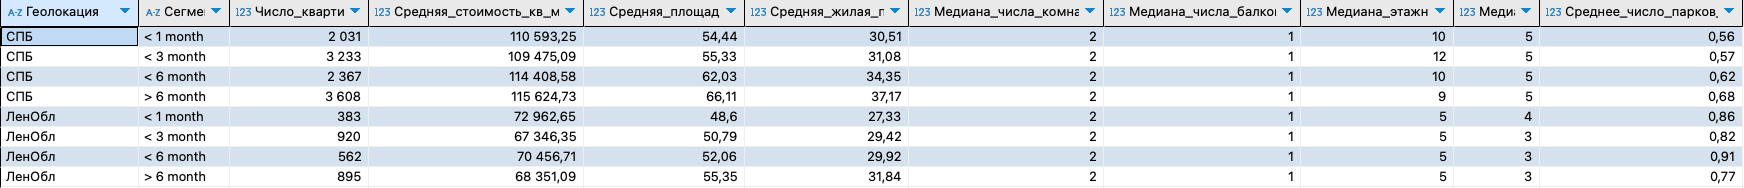

        Все данные были разделены на две категории - СПБ и ЛенОбл. Внутри каждой категории все объявления делятся на 4 сегмента: объявления, которые существовали до 1 месяца, до 3 месяцев, до 6 месяцев и более 6 месяцев. 

        В Санкт-Петербурге больше квартир, которые продаются дольше 6 месяцев, а именно 3608 квартир из представленных данных. В городах Ленинградской Области на первом месте по числу квартир сегмент активности от 1 до 3 месяцев - 920 квартир. 


        Можно заметить, что наиболее дорогие квартиры продаются дольше остальных. Это правило подходит для СПБ, где средняя стоимость квадратного метра квартир, продающихся > 6 месяцев, составляет > 115 000 рублей. Однако с самой низкой ценой за метр - < 110 000 рублей - являются квартиры, продающиеся до 3 месяцев. Быстрее всего “уходят” квартиры со средней ценой метра < 111 000 рублей. 
    
        Можно предположить, что для покупателей в СПБ цена является основным, но не главным фактором выбора квартиры, поэтому самые дешевые квартиры не уходят быстрее всего. Площадь квартир в данном исследовании чаще всего пропорциональна цене, а количество комнат и балконов никак не влияют на скорость продажи, чего нельзя сказать об этажности дома, в котором находится квартира. Так помещения в 9 - этажных домах продаются дольше всего, а быстрее всего - в 10 и 12 - этажных.
    
        В Ленинградской Области увеличение площади квартиры увеличивает срок ее продажи, однако к цене метра квартиры это правило не применяется - самые дорогие квартиры уходят менее, чем за месяц, в то время как дольше всего продаются квартиры почти с самой низкой ценой - > 63 000 за квадратный метр. 
    
        Можно предположить, что в Области большим спросом пользуется более дорогое жилье в новых домах, а в Санкт-Петербурге предпочтение отдается менее дорогим квартирам на рынке.


        Цены на квартиры в Санкт-Петербурге примерно в 1,5 раза выше, чем в Лен Области, при этом число парков рядом с домами в регионе больше.


## 2. Для анализа cезонности объявлений отвечу на следующие вопросы:
- В какие месяцы наблюдается наибольшая активность в публикации объявлений о продаже недвижимости? А в какие — по снятию? Это показывает динамику активности покупателей.
-  Совпадают ли периоды активной публикации объявлений и периоды, когда происходит повышенная продажа недвижимости (по месяцам снятия объявлений)?
- Как сезонные колебания влияют на среднюю стоимость квадратного метра и среднюю площадь квартир? Что можно сказать о зависимости этих параметров от месяца?


In [ ]:
q2 = '''
WITH limits AS (   -- Фильтр от артефактов
    SELECT  
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY total_area) AS total_area_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY rooms) AS rooms_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY balcony) AS balcony_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY ceiling_height) AS ceiling_height_limit_h,
        PERCENTILE_DISC(0.01) WITHIN GROUP (ORDER BY ceiling_height) AS ceiling_height_limit_l
    FROM real_estate.flats     
),
filtered_id AS(
    SELECT id
    FROM real_estate.flats  
    WHERE 
        total_area < (SELECT total_area_limit FROM limits)
        AND (rooms < (SELECT rooms_limit FROM limits) OR rooms IS NULL)
        AND (balcony < (SELECT balcony_limit FROM limits) OR balcony IS NULL)
        AND ((ceiling_height < (SELECT ceiling_height_limit_h FROM limits)
            AND ceiling_height > (SELECT ceiling_height_limit_l FROM limits)) OR ceiling_height IS NULL)
    ) 
SELECT to_char(first_day_exposition, 'month') AS месяц, -- основной запрос
	count(first_day_exposition) AS публикаций,
	ROW_NUMBER() OVER (ORDER BY count(first_day_exposition) desc) AS ранг_по_публикациям,
	count(first_day_exposition + days_exposition * INTERVAL '1 day') AS продаж,
	ROW_NUMBER() OVER (ORDER BY count(first_day_exposition + days_exposition * INTERVAL '1 day') desc) AS ранг_по_продажам,
	round((avg(last_price::real / total_area))::numeric, 2) AS ср_стоимость_кв_м,
	round(avg(total_area)::numeric, 2) AS cр_площадь
FROM real_estate.flats f LEFT JOIN real_estate.advertisement a USING (id) LEFT JOIN real_estate."type" t USING (type_id)
WHERE id IN (SELECT * FROM filtered_id) AND (first_day_exposition BETWEEN '2015-01-01'::date AND '2018-12-31'::date) -- учитываю только годы, данные по которым есть за каждый месяц
	AND t.type = 'город'
GROUP BY месяц
'''

Резуьтат

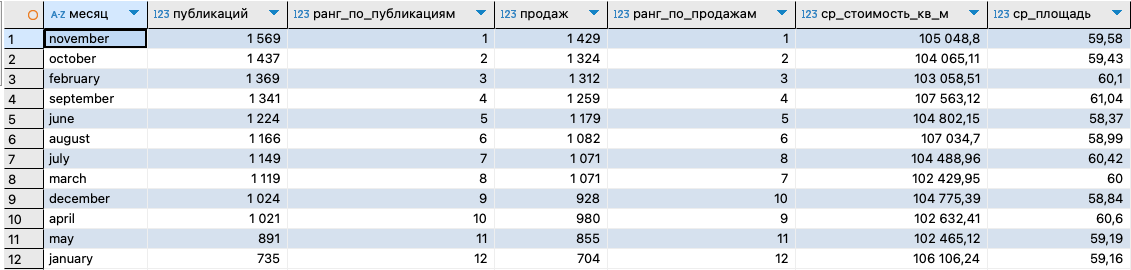

        Все месяцы осени, февраль и июнь - входят в топ 5 месяцев по выложенным объявлениям. Так за Ноябри с 2015 по 2018 включительно было выложено > 1500 объявлений. Топ месяцев по снятию объявлений остается таким же

        Топ месяцев по снятию объявлений почти полностью совпадает с топом по выкладыванию объявлений с небольшим изменением. Так декабрь (9 место по выложенным объявлениям) меняется местами с апрелем (10 место по выложенным объявлениям) в топе по снятию объявлений.


        Можно заметить, что самые дешевые квартиры выставляются весной - март, апрель, май. Самые дорогие квартиры - сентябрь, август, январь. В сентябре цены, как и площади, на квартиры растут - > 107 000 за метр и в среднем > 61 кв. метров, но это не мешает им хорошо продаваться не смотря на самый высокий показатель стоимости за квадратный метр (4 место по публикациям и снятиям объявлений).
        
        В апреле, январе и мае квартиры продаются и выкладываются реже всего, а самые маленькие квартиры оборачиваются именно в июне, августе и декабре.


## 3. Для анализа рынка недвижимости Ленобласти отвечу на следующие вопросы:
- В каких населённые пунктах Ленинградской области наиболее активно публикуют объявления о продаже недвижимости?
- В каких населённых пунктах Ленинградской области — самая высокая доля снятых с публикации объявлений? Это может указывать на высокую долю продажи недвижимости.
- Какова средняя стоимость одного квадратного метра и средняя площадь продаваемых квартир в различных населённых пунктах? Есть ли вариация значений по этим метрикам?
- Среди выделенных населённых пунктов какие пункты выделяются по продолжительности публикации объявлений? То есть где недвижимость продается быстрее, а где — медленнее.



In [55]:
q3 = '''
WITH limits AS (   -- Фильтр от артефактов
    SELECT  
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY total_area) AS total_area_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY rooms) AS rooms_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY balcony) AS balcony_limit,
        PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY ceiling_height) AS ceiling_height_limit_h,
        PERCENTILE_DISC(0.01) WITHIN GROUP (ORDER BY ceiling_height) AS ceiling_height_limit_l
    FROM real_estate.flats     
),
filtered_id AS(
    SELECT id
    FROM real_estate.flats  
    WHERE 
        total_area < (SELECT total_area_limit FROM limits)
        AND (rooms < (SELECT rooms_limit FROM limits) OR rooms IS NULL)
        AND (balcony < (SELECT balcony_limit FROM limits) OR balcony IS NULL)
        AND ((ceiling_height < (SELECT ceiling_height_limit_h FROM limits)
            AND ceiling_height > (SELECT ceiling_height_limit_l FROM limits)) OR ceiling_height IS NULL)
    ),
percentile_90 AS( -- вычисляю персентиль 90, что бы найти населенные пункты, которые вхолят в 10% пунктов ко колличеству публикаций
	SELECT percentile_disc(0.9) WITHIN GROUP (ORDER BY публикаций)
	FROM (SELECT city_id, count(*) AS публикаций FROM real_estate.flats f  WHERE id IN (SELECT * FROM filtered_id) GROUP BY city_id) AS cc 
)
SELECT * -- основной запрос
FROM (
	SELECT city, -- все, что интересует
		count(*) AS публикаций, 
		round(count(*) FILTER (WHERE days_exposition IS NOT NULL) / count(*)::NUMERIC, 2) AS доля_снятых_объявл,
		round(avg(total_area)::numeric, 2) AS ср_площадь_квартир,
		round(avg(last_price::REAL / total_area)::numeric, 2) AS Средняя_стоимость_кв_метра,
		round(avg(days_exposition)::numeric, 2) AS ср_продолжительность_объявл
	FROM real_estate.flats f 
	LEFT JOIN real_estate.city c USING (city_id)
	LEFT JOIN real_estate.advertisement a USING (id)
	WHERE id IN (SELECT * FROM filtered_id) 
	GROUP BY city
) AS base
WHERE публикаций > (SELECT * FROM percentile_90) AND city <> 'Санкт-Петербург' -- вывожу только 10% лучших пунктов по числу объявлений 
ORDER BY публикаций desc
'''

Результат

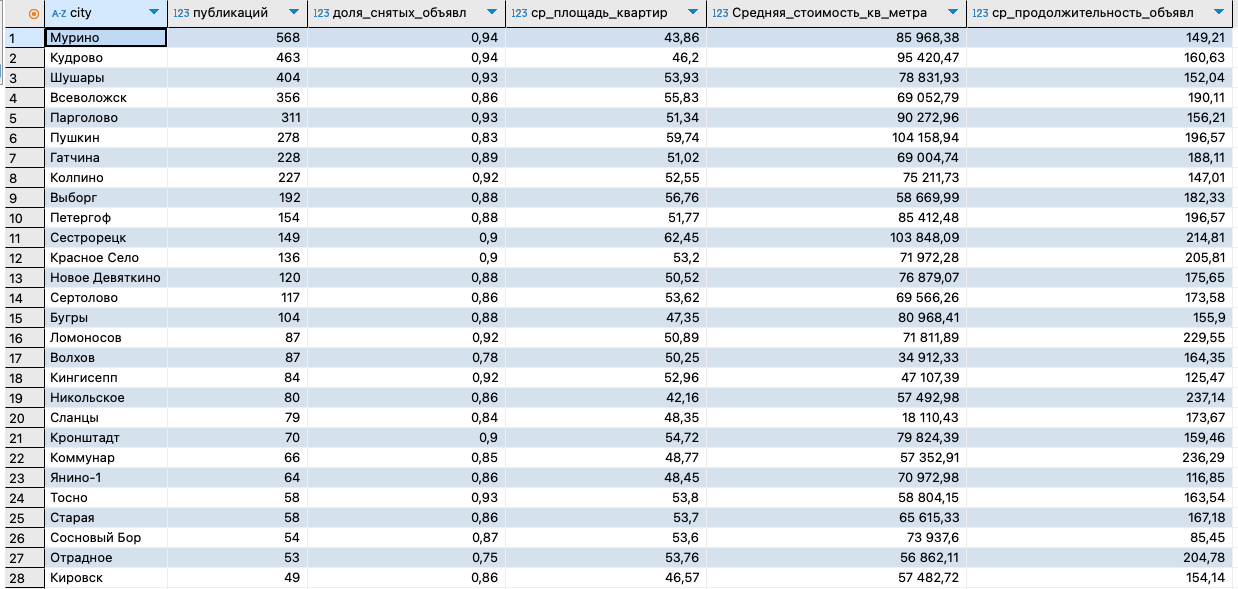

        Мурино, Кудрово, Шушары, Всеволожск и Парголово занимают первые позиции по числу объявлений и имеют 568, 463, 404, 356 и 311 объявлений соответственно.


         Так же Мурино, Кудрово, Шушары, Парголово и Тосно имеют свыше 93 % снятый объявлений, что может свидетельствовать на высокую долю продажи недвижимости в этих населенных пунктах.


        Города с самой высокой стоимостью квадратного метра: Пушкин, Сестрорецк, Кудрово, Парголово. Города с самой высокой средней площадью квартир на продажу: Сестрорецк, Пушкин, Выборг, Всеволожск


        Города с самой высокой скоростью продажи квартиры: Сосновый Бор, Янино-1, Кингисепп, Колпино, Мурино. Города с самой низкой скоростью продажи квартиры: Никольское, Коммунар, Ломоносов, Сестрорецк, Красное Село


## Дашборд

### Итоговый дашборд должен показывать статистику по выложенным объявлениям о продаже квартир в Санкт-Петербурге и Ленинградской Области по данным Яндекс Недвижимости за период с 2014 по 2019 гг.

С дашбордом предлагаю ознакомиться по ссылке

https://datalens.yandex/5sl1sqsrlkear

## 4.Общие выводы и рекомендации

        На основании анализируемых данных можно сделать вывод, что Санкт-Петербург является лидером по числу объявлений, продаж, стоимости квартир. Все месяцы осени, февраль и июнь являются самыми динамичными месяцами на рынке недвижимости. Быстрее всего в Санкт-Петербурге продаются квартиры со стоимостью квадратного метра ниже 111 000 рублей и площадью менее 55 квадратных метров.

        Наибольшая доля проданных квартир вычисляются в следующих регионах: Мурино, Кудрово, Шушары, Парголово и Тосно. В Ленинградской области быстрее всего продаются квартиры общей площадью менее 51 квадратного метра, при этом самые дорогие квартиры находятся в Пушкин, Сестрорецк, Кудрово, Парголово.
